<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw1/hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you load this notebook by clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement autoregressive models and run it on various datasets. Oftentime you will run it on two datasets (dataset 1 and dataset 2). In these cases, the expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the images outputted in the results/ folder and upload them to the figure folder in the given latex template.

There is a lot of freedom in this homework to design write and design your own models. Hyperparameters are given as a guide to show what worked for us, but feel free to explore and use what you find is best!

Run the cells below to download and load up the starter code.

In [ ]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
!pip install ./deepul

In [1]:
import numpy as np
from deepul.hw1_helper import (
    # Q1
    visualize_q1_data,
    q1_sample_data_1,
    q1_sample_data_2,
    q1_save_results,
    # Q2
    q2a_save_results,
    q2b_save_results,
    visualize_q2a_data,
    visualize_q2b_data,
    # Q3
    q3ab_save_results,
    q3c_save_results,
    # Q4
    q4a_save_results,
    q4b_save_results,
    # Q5
    visualize_q5_data,
    q5a_save_results,
    # Q6
    visualize_q6_data,
    q6a_save_results,
)

# Question 1: 1D Data

In this question, we will train simple generative models on discrete 1D data.

Execute the cell below to visualize our datasets

Dataset 1


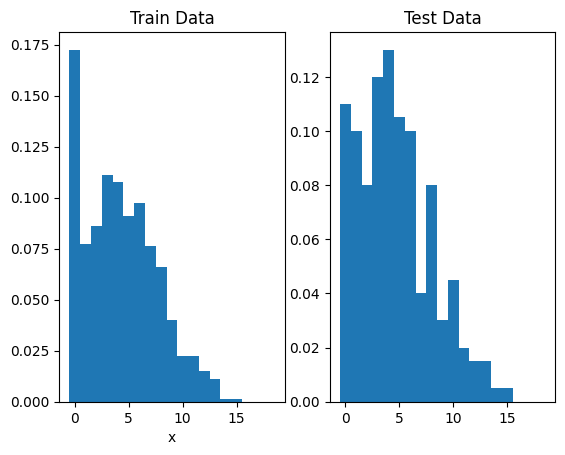

Dataset 2


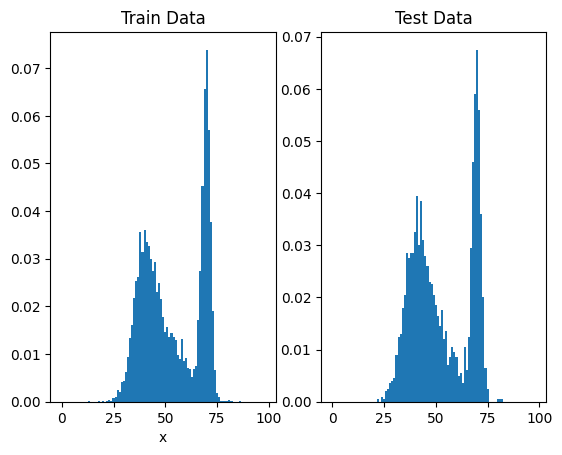

In [16]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Fitting a Histogram

Let $\theta = (\theta_0, \dots, \theta_{d-1}) \in \mathbb{R}^{d}$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Plot the model probabilities in a bar graph with $\{0,\dots,d-1\}$ on the x-axis and a real number in $[0,1]$ on the y-axis.




Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import tqdm

# AR: 优化参数theta使得ptheta接近真实分布 => 最小化KL散度
def q1_a(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for random variable x 随机变量x的可能离散值的数量
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """
  batch_size = 128
  num_epochs = 300
  lr = 0.1 if dset_id == 1 else 0.05

  train_tensor = torch.tensor(train_data, dtype=torch.long)
  test_tensor = torch.tensor(test_data, dtype=torch.long)
  train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)

  theta = torch.zeros(d, requires_grad=True)
  optimizer = torch.optim.SGD([theta], lr=lr)
  train_losses = []
  test_losses = []

  def compute_nll(data):
    logits = theta
    log_probs = logits - torch.logsumexp(logits, dim=0)
    nll = -log_probs[data].mean()
    return nll

  with torch.no_grad():
    test_losses.append(compute_nll(test_tensor).item())

  for epoch in range(num_epochs):
    for batch in train_loader:
      optimizer.zero_grad()
      loss = compute_nll(batch)
      loss.backward()
      optimizer.step()
      train_losses.append(loss.item())

    with torch.no_grad():
      test_losses.append(compute_nll(test_tensor).item())

    distribution = torch.softmax(theta, dim=0).detach().numpy() # 最终的分布

  return train_losses, test_losses, distribution

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



Final Test Loss: 2.5533


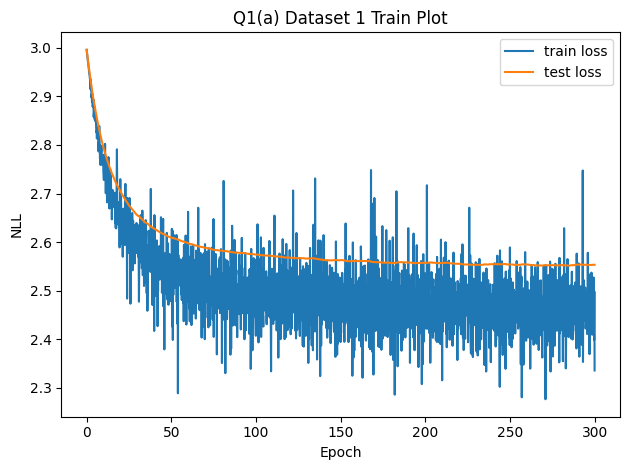

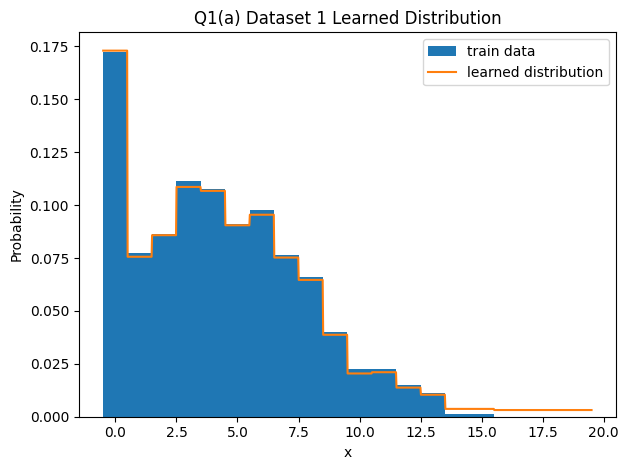

In [18]:
q1_save_results(1, 'a', q1_a)

Final Test Loss: 3.6821


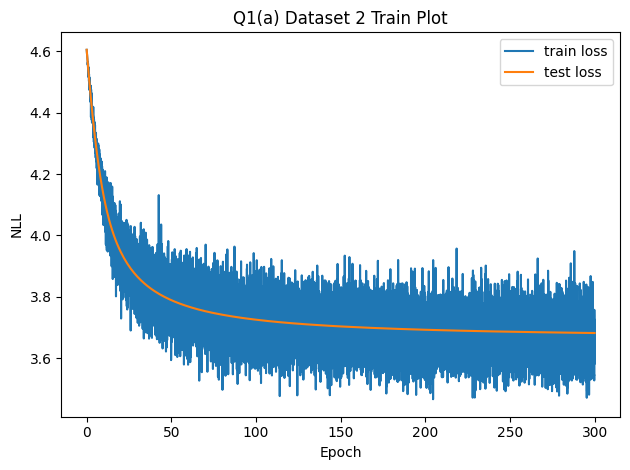

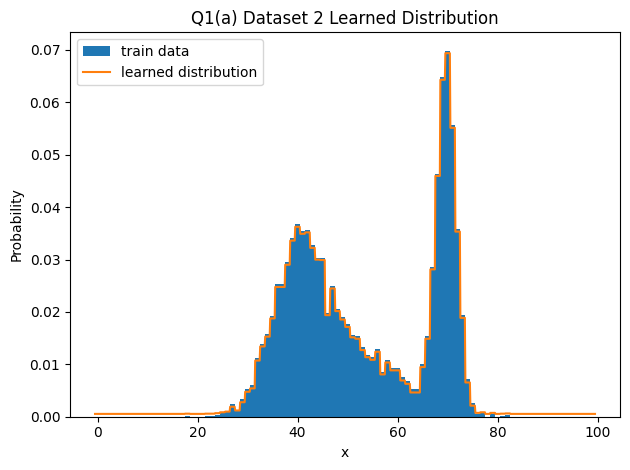

In [19]:
q1_save_results(2, 'a', q1_a)

## Part (b) Fitting Discretized Mixture of Logistics

Let us model $p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = 99$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.

**Provide the same set of corresponding deliverables as part (a)**

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q1_b(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """
  return train_losses, test_losses, distribution

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



In [ ]:
q1_save_results(1, 'b', q1_b)

In [ ]:
q1_save_results(2, 'b', q1_b)

# Question 2 PixelCNNs

Now, you will train more powerful PixelCNN models on the shapes dataset and MNIST. In addition, we will extend to modeling colored datasets.

Run the cell below to visualize the two datasets binary datasets

In [ ]:
visualize_q2a_data(1)
visualize_q2a_data(2)

## Part (a) PixelCNN on Shapes and MNIST
In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images (same as Q2(b), but with a PixelCNN).

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network. 

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

Checkout the Paper for more details: https://arxiv.org/abs/1601.06759

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q2_a(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  image_shape: (H, W), height and width of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """
  return train_losses, test_losses, samples

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



In [ ]:
q2a_save_results(1, q2_a)

In [ ]:
q2a_save_results(2, q2_a)

## Part (b) PixelCNN on Colored Shapes and MNIST: Independent Color Channels

For the next part, we'll work with color images (shapes and MNIST). Run the cell below to visualize the dataset.

In [ ]:
visualize_q2b_data(1)
visualize_q2b_data(2)

Now, implement a PixelCNN to support RGB color channels (or augment your existing implementation). **First, implement a PixelCNN that assumes color channels as independent.** More formally, we model the following parameterized distribution:

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_{<i})$$

Here are some tips that you may find useful for designing and training these models:
* You will need a 4-way softmax for every prediction, as opposed to a 256-way softmax in the PixelCNN paper, since the dataset is quantized to two bits per color channel
* You can set the number of filters for each convolutions to 120. You can use the ReLU nonlinearity throughout.
* Use a stack of 8 residual block architecture from [Figure 5](https://arxiv.org/abs/1601.06759) but with 7 x 7 masked convolutions in the middle instead of 3 x 3 masked convolutions
* Consider using [layer normalization](https://arxiv.org/abs/1607.06450) to improve performance. However, be careful to maintain the autoregressive property.
* With a learning rate of $10^{-3}$ and a batch size of 128, it should take a few minutes to run on the shapes dataset, and about 50-60 minutes on MNIST.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q2_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """
  return train_losses, test_losses, samples

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



In [ ]:
q2b_save_results(1, 'b', q2_b)

In [ ]:
q2b_save_results(2, 'b', q2_b)

# Question 3: Causal Transformer - iGPT

Now we will move onto the current most popular and widespread autoregressive model, the transformer.

## Part (a) Autoregressive Transformer on Shapes and MNIST
In this part, implement a simple Autoregressive Transformer to model binary MNIST and shapes images (same as Q2(a), but with a Transformer). 

Some additional notes about your transformer implementation:
 * iGPT uses learned positional encodings. We recommend to use those here as well. However, you may also use sinusoidal positional encodings if you wish (see the [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper)
 * Autoregressive transformer always predicts the **next** token, give prior tokens. iGPT has a special **\<bos\>** or beginning of sequence token at the start of every sequence every image. Make sure to include this in your implementation as well. You can generate unconditional sample by conditioning with the **\<bos\>** token.
 * While dropout is a common feature in transformer models, you do not need to add it (but may if you wish!).
 * Prebuilt transformers exist in some frameworks (i.e. pytorch). Don't just use an off the shelf implementation as the point of the exercise is to better understand the transformer architecture. Building the transformer from the ground up (use primitives such as Linear/Dense layers, LayerNorm, GeLU, Embedding)
 * Learning rate warmup and cos learning rate decay are often used when training transformers to improve training stability and improve performance. See if this helps your model! Try 1000 steps of warmup with a cosine learning rate decay.

Paper references
* [Attention Is All You Need](https://arxiv.org/abs/1706.03762) 
* [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf) 
* [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

We recommend the following network design parameters:
* $d_{model}$: 128
* heads: 4
* layers: 2
* GeLU nonlinearities

And the following hyperparameters:
* Batch size: 64 or 32 or 16 (whichever fits in your GPU)
* Learning rate: $10^{-3}$
* 15 epochs or more
* Adam Optimizer (this applies to all Transformers models trained in future parts)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 100 samples from the final trained model



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import math
import tqdm

class LearnedPositionalEncoding(nn.Module):
  def __init__(self, max_len, d_model):
    super().__init__()
    self.pos_embed = nn.Embedding(max_len, d_model)

  def forward(self, x):
    B, T, _ = x.shape
    positions = torch.arange(T, device=x.device).unsqueeze(0).expand(B, T)
    return self.pos_embed(positions)

class MaskedMultiHeadAttention(nn.Module):
  def __init__(self, d_model, n_heads):
    super().__init__()
    self.n_heads = n_heads
    self.d_model = d_model
    self.head_dim = d_model // n_heads
    assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
    self.qkv_proj = nn.Linear(d_model, d_model * 3)
    self.out_proj = nn.Linear(d_model, d_model)
    
  def forward(self, x, mask):
    B, T, D = x.shape
    qkv = self.qkv_proj(x).reshape(B, T, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4) # (3, B, n_heads, T, head_dim)
    q, k, v = qkv[0], qkv[1], qkv[2]  # (B, n_heads, T, head_dim)

    scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)
    scores = scores.masked_fill(mask == 0, float('-inf'))
    attn = F.softmax(scores, dim=-1)

    out = (attn @ v).transpose(1, 2).reshape(B, T, D)
    return self.out_proj(out)

class TransformerBlock(nn.Module):
  def __init__(self, d_model, n_heads):
    super().__init__()
    self.attn = MaskedMultiHeadAttention(d_model, n_heads)
    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)
    self.ff = nn.Sequential(
        nn.Linear(d_model, d_model * 4),
        nn.GELU(),
        nn.Linear(d_model * 4, d_model)
    )
  def forward(self, x, mask):
    """
    x: (B, T, d_model)
    mask: (B, T, T) where mask[i, j] = 1 if position i attends to position j, else 0
    """
    x = x + self.attn(self.norm1(x), mask)
    x = x + self.ff(self.norm2(x))
    return x
  
class AutoregressiveTransformer(nn.Module):
  def __init__(self, seq_len, d_model=128, n_heads=4, n_layers=2, vocab_size=2):
    super().__init__()
    self.seq_len = seq_len
    self.d_model = d_model
    self.n_heads = n_heads
    self.n_layers = n_layers
    self.vocab_size = vocab_size

    self.token_embed = nn.Embedding(vocab_size, d_model)
    self.pos_embed = LearnedPositionalEncoding(seq_len, d_model)
    self.transformer_blocks = nn.ModuleList([
      TransformerBlock(d_model, n_heads) for _ in range(n_layers)
    ])
    self.norm = nn.LayerNorm(d_model)
    self.output_proj = nn.Linear(d_model, vocab_size)
  def forward(self, x):
    """
    x: (B, T)
    """
    B, T = x.shape
    token_embeddings = self.token_embed(x) # (B, T, d_model)
    pos_embeddings = self.pos_embed(token_embeddings) # (B, T, d_model)
    x = token_embeddings + pos_embeddings # (B, T, d_model)
    mask = torch.tril(torch.ones(T, T, device=x.device)).unsqueeze(0).unsqueeze(0) # (1, 1, T, T)
    for block in self.transformer_blocks:
      x = block(x, mask)
    x = self.norm(x)
    logits = self.output_proj(x)
    return logits # (B, T, vocab_size)
  
  def sample(self, batch_size, device):
    x = torch.zeros(batch_size, 1, dtype=torch.long, device=device) # <bos>
    for _ in range(self.seq_len - 1):
      logits = self.forward(x) # (B, T, vocab_size)
      probs = F.softmax(logits[:, -1, :], dim=-1) # (B, vocab_size)
      next_token = torch.multinomial(probs, num_samples=1)
      x = torch.cat([x, next_token], dim=1)
    return x # (B, T)

def q3_a(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H高度, W宽度, 1通道数) uint8 numpy array of color images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of color images with values in {0, 1}
  image_shape: (H, W, 1), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
          used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """
  batch_size = 64
  num_epochs = 25 if dset_id == 1 else 35
  lr = 0.001
  H, W, _ = image_shape
  seq_len = H * W + 1
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

  train_x = train_data.reshape(len(train_data), -1)
  test_x = test_data.reshape(len(test_data), -1)
  train_x = torch.from_numpy(train_data.reshape(len(train_data), -1)).long()
  test_x = torch.from_numpy(test_data.reshape(len(test_data), -1)).long()
  train_dataset = TensorDataset(train_x)
  test_dataset = TensorDataset(test_x)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size)

  model = AutoregressiveTransformer(seq_len=seq_len, d_model=128, n_heads=4, n_layers=2, vocab_size=2).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.001)
  train_losses = []
  test_losses = []

  def nll(x, device):
    x = x.to(device)
    bos = torch.zeros(x.shape[0], 1, dtype=torch.long, device=device)
    x_in = torch.cat([bos, x[:, :-1]], dim=1)
    logits = model(x_in)
    loss = F.cross_entropy(logits.view(-1, 2), x.view(-1), reduction='none')
    return loss.view(x.shape).sum(dim=1).mean()

  def compute_nll(data_loader):
    model.eval()
    losses = []
    with torch.no_grad():
      for (x,) in data_loader:
        loss = nll(x, device)
        losses.append(loss.item())
    return np.mean(losses)

  test_losses.append(compute_nll(test_loader))

  step = 0
  for epoch in range(num_epochs):
    model.train()
    for (x,) in tqdm.tqdm(train_loader, desc=f"Epoch {epoch}"):
      loss = nll(x, device)
      train_losses.append(loss.item())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      scheduler.step()

    test_loss = compute_nll(test_loader)
    test_losses.append(test_loss)
    print("test loss:", test_loss)

  with torch.no_grad():
    samples = model.sample(100, device=device).cpu().numpy()
    samples = samples[:, 1:]
    samples = samples.reshape(100, H, W, 1)

  return train_losses, test_losses, samples

### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results

Epoch 0: 100%|██████████| 164/164 [00:03<00:00, 41.45it/s]


test loss: 35.10316797713159


Epoch 1: 100%|██████████| 164/164 [00:03<00:00, 41.31it/s]


test loss: 26.678769420570053


Epoch 2: 100%|██████████| 164/164 [00:03<00:00, 41.25it/s]


test loss: 23.43691398728062


Epoch 3: 100%|██████████| 164/164 [00:03<00:00, 41.16it/s]


test loss: 20.271824608386403


Epoch 4: 100%|██████████| 164/164 [00:03<00:00, 41.10it/s]


test loss: 19.04858427987972


Epoch 5: 100%|██████████| 164/164 [00:04<00:00, 40.96it/s]


test loss: 18.493834697024923


Epoch 6: 100%|██████████| 164/164 [00:04<00:00, 40.95it/s]


test loss: 17.61039868207045


Epoch 7: 100%|██████████| 164/164 [00:04<00:00, 40.93it/s]


test loss: 17.170765084280095


Epoch 8: 100%|██████████| 164/164 [00:04<00:00, 40.92it/s]


test loss: 16.582898610074754


Epoch 9: 100%|██████████| 164/164 [00:04<00:00, 40.91it/s]


test loss: 16.29458048645879


Epoch 10: 100%|██████████| 164/164 [00:04<00:00, 40.89it/s]


test loss: 16.120462108665787


Epoch 11: 100%|██████████| 164/164 [00:04<00:00, 40.90it/s]


test loss: 16.04417287799674


Epoch 12: 100%|██████████| 164/164 [00:04<00:00, 40.88it/s]


test loss: 15.531743277966136


Epoch 13: 100%|██████████| 164/164 [00:04<00:00, 40.82it/s]


test loss: 15.45760885426696


Epoch 14: 100%|██████████| 164/164 [00:04<00:00, 40.83it/s]


test loss: 15.377229583095497


Epoch 15: 100%|██████████| 164/164 [00:04<00:00, 40.81it/s]


test loss: 15.15669305559615


Epoch 16: 100%|██████████| 164/164 [00:04<00:00, 40.81it/s]


test loss: 15.055636405944824


Epoch 17: 100%|██████████| 164/164 [00:04<00:00, 40.85it/s]


test loss: 14.875785223195251


Epoch 18: 100%|██████████| 164/164 [00:04<00:00, 40.84it/s]


test loss: 14.897916484886492


Epoch 19: 100%|██████████| 164/164 [00:04<00:00, 40.87it/s]


test loss: 14.807618248630577


Epoch 20: 100%|██████████| 164/164 [00:04<00:00, 40.86it/s]


test loss: 14.506663483633123


Epoch 21: 100%|██████████| 164/164 [00:04<00:00, 40.85it/s]


test loss: 14.63493772963403


Epoch 22: 100%|██████████| 164/164 [00:04<00:00, 40.80it/s]


test loss: 14.441533263300506


Epoch 23: 100%|██████████| 164/164 [00:04<00:00, 40.78it/s]


test loss: 14.501957235201983


Epoch 24: 100%|██████████| 164/164 [00:04<00:00, 40.78it/s]


test loss: 14.398695502482669
Final Test Loss: 14.3987


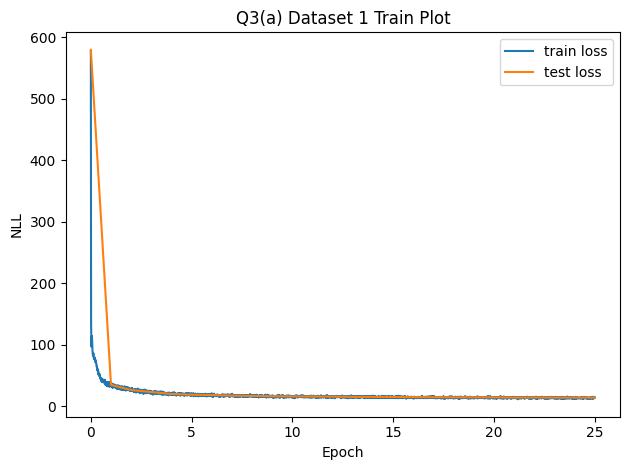

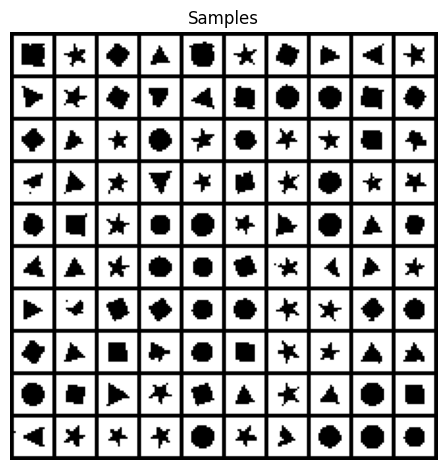

In [12]:
q3ab_save_results(1, 'a', q3_a)

Epoch 0: 100%|██████████| 938/938 [01:05<00:00, 14.35it/s]


test loss: 80.21414053364164


Epoch 1: 100%|██████████| 938/938 [01:05<00:00, 14.31it/s]


test loss: 72.9187005401417


Epoch 2: 100%|██████████| 938/938 [01:05<00:00, 14.31it/s]


test loss: 69.97927705801217


Epoch 3: 100%|██████████| 938/938 [01:05<00:00, 14.31it/s]


test loss: 67.624614594089


Epoch 4: 100%|██████████| 938/938 [01:05<00:00, 14.31it/s]


test loss: 66.46612500233256


Epoch 5: 100%|██████████| 938/938 [01:05<00:00, 14.31it/s]


test loss: 65.42023613802186


Epoch 6: 100%|██████████| 938/938 [01:05<00:00, 14.32it/s]


test loss: 64.86752917052834


Epoch 7: 100%|██████████| 938/938 [01:05<00:00, 14.32it/s]


test loss: 64.17052056379379


Epoch 8: 100%|██████████| 938/938 [01:05<00:00, 14.31it/s]


test loss: 63.89395440460011


Epoch 9: 100%|██████████| 938/938 [01:05<00:00, 14.32it/s]


test loss: 63.14038353209283


Epoch 10: 100%|██████████| 938/938 [01:05<00:00, 14.31it/s]


test loss: 62.659038009157605


Epoch 11: 100%|██████████| 938/938 [01:05<00:00, 14.32it/s]


test loss: 62.448739167231665


Epoch 12: 100%|██████████| 938/938 [01:05<00:00, 14.32it/s]


test loss: 62.250917422543665


Epoch 13: 100%|██████████| 938/938 [01:05<00:00, 14.31it/s]


test loss: 62.00807496089085


Epoch 14: 100%|██████████| 938/938 [01:05<00:00, 14.31it/s]


test loss: 61.68688607671458


Epoch 15: 100%|██████████| 938/938 [01:05<00:00, 14.32it/s]


test loss: 61.68677897362193


Epoch 16: 100%|██████████| 938/938 [01:05<00:00, 14.31it/s]


test loss: 61.395042832489985


Epoch 17: 100%|██████████| 938/938 [01:05<00:00, 14.31it/s]


test loss: 61.1727853276927


Epoch 18: 100%|██████████| 938/938 [01:05<00:00, 14.31it/s]


test loss: 61.093169971636144


Epoch 19: 100%|██████████| 938/938 [01:05<00:00, 14.31it/s]


test loss: 61.01814425523114


Epoch 20: 100%|██████████| 938/938 [01:05<00:00, 14.32it/s]


test loss: 60.92268590258944


Epoch 21: 100%|██████████| 938/938 [01:05<00:00, 14.31it/s]


test loss: 60.88272335271167


Epoch 22: 100%|██████████| 938/938 [01:05<00:00, 14.31it/s]


test loss: 60.77985267882134


Epoch 23: 100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


test loss: 60.621624819032704


Epoch 24: 100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


test loss: 60.58355691022933


Epoch 25: 100%|██████████| 938/938 [01:05<00:00, 14.31it/s]


test loss: 60.4905206716744


Epoch 26: 100%|██████████| 938/938 [01:05<00:00, 14.31it/s]


test loss: 60.46751216718346


Epoch 27: 100%|██████████| 938/938 [01:05<00:00, 14.31it/s]


test loss: 60.59527021760394


Epoch 28: 100%|██████████| 938/938 [01:05<00:00, 14.32it/s]


test loss: 60.50722146489817


Epoch 29: 100%|██████████| 938/938 [01:05<00:00, 14.31it/s]


test loss: 60.41025001380094


Epoch 30: 100%|██████████| 938/938 [01:05<00:00, 14.31it/s]


test loss: 60.26601266557244


Epoch 31: 100%|██████████| 938/938 [01:05<00:00, 14.31it/s]


test loss: 60.48076291904328


Epoch 32: 100%|██████████| 938/938 [01:05<00:00, 14.31it/s]


test loss: 60.30865692333052


Epoch 33: 100%|██████████| 938/938 [01:05<00:00, 14.31it/s]


test loss: 60.319251090857634


Epoch 34: 100%|██████████| 938/938 [01:05<00:00, 14.31it/s]


test loss: 60.39705514604119
Final Test Loss: 60.3971


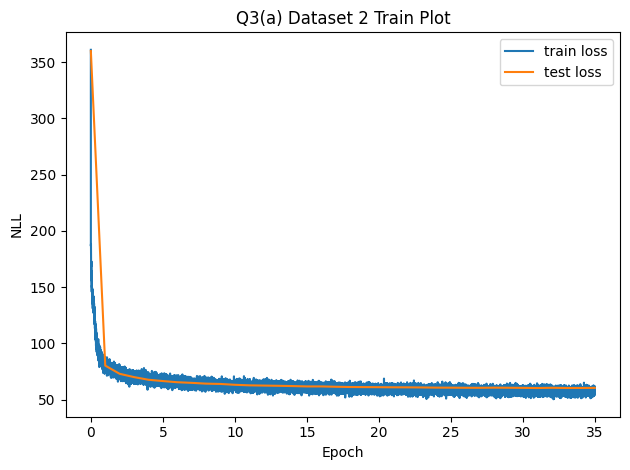

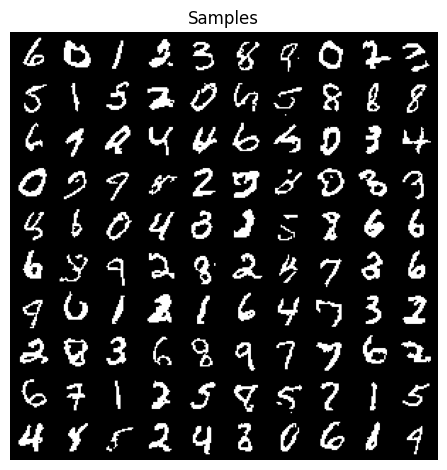

In [15]:
q3ab_save_results(2, 'a', q3_a)

## Part (b) iGPT on Colored Shapes and MNIST

Now, implement an iGPT that models color. In order to reduce the length of token sequences, iGPT models each RGB pixel as a **single** token. This effectively reduces the context length from H*W*C to just H*W. iGPT does this through a k-means clustering approach. Because our images only each can only take on 4 values (2 bits) per channel, we can represent each pixel with 64 values (6 bits). Convert the dataset into an image of tokens and train iGPT on the colored shapes and MNIST dataset.

Checkout the iGPT paper for more details: [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf) 

Training times and hyperparameter settings should be the same as part (a), except train for longer (15 epochs)

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import math
import tqdm
import os

class LearnedPositionalEncoding(nn.Module):
  def __init__(self, max_len, d_model):
    super().__init__()
    self.pos_embed = nn.Embedding(max_len, d_model)

  def forward(self, x):
    B, T, _ = x.shape
    positions = torch.arange(T, device=x.device).unsqueeze(0).expand(B, T)
    return self.pos_embed(positions)

class MaskedMultiHeadAttention(nn.Module):
  def __init__(self, d_model, n_heads):
    super().__init__()
    self.n_heads = n_heads
    self.d_model = d_model
    self.head_dim = d_model // n_heads
    assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
    self.qkv_proj = nn.Linear(d_model, d_model * 3)
    self.out_proj = nn.Linear(d_model, d_model)
    
  def forward(self, x, mask):
    B, T, D = x.shape
    qkv = self.qkv_proj(x).reshape(B, T, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4) # (3, B, n_heads, T, head_dim)
    q, k, v = qkv[0], qkv[1], qkv[2]  # (B, n_heads, T, head_dim)

    scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)
    scores = scores.masked_fill(mask == 0, float('-inf'))
    attn = F.softmax(scores, dim=-1)

    out = (attn @ v).transpose(1, 2).reshape(B, T, D)
    return self.out_proj(out)

class TransformerBlock(nn.Module):
  def __init__(self, d_model, n_heads):
    super().__init__()
    self.attn = MaskedMultiHeadAttention(d_model, n_heads)
    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)
    self.ff = nn.Sequential(
        nn.Linear(d_model, d_model * 4),
        nn.GELU(),
        nn.Linear(d_model * 4, d_model)
    )
  def forward(self, x, mask):
    """
    x: (B, T, d_model)
    mask: (B, T, T) where mask[i, j] = 1 if position i attends to position j, else 0
    """
    x = x + self.attn(self.norm1(x), mask)
    x = x + self.ff(self.norm2(x))
    return x
  
class AutoregressiveTransformer(nn.Module):
  def __init__(self, seq_len, d_model=128, n_heads=4, n_layers=2, vocab_size=64):
    super().__init__()
    self.seq_len = seq_len
    self.d_model = d_model
    self.n_heads = n_heads
    self.n_layers = n_layers
    self.vocab_size = vocab_size

    self.token_embed = nn.Embedding(vocab_size, d_model)
    self.pos_embed = LearnedPositionalEncoding(seq_len, d_model)
    self.transformer_blocks = nn.ModuleList([
      TransformerBlock(d_model, n_heads) for _ in range(n_layers)
    ])
    self.norm = nn.LayerNorm(d_model)
    self.output_proj = nn.Linear(d_model, vocab_size)
    
  def forward(self, x):
    """
    x: (B, T)
    """
    B, T = x.shape
    token_embeddings = self.token_embed(x) # (B, T, d_model)
    pos_embeddings = self.pos_embed(token_embeddings) # (B, T, d_model)
    x = token_embeddings + pos_embeddings # (B, T, d_model)
    mask = torch.tril(torch.ones(T, T, device=x.device)).unsqueeze(0).unsqueeze(0) # (1, 1, T, T)
    for block in self.transformer_blocks:
      x = block(x, mask)
    x = self.norm(x)
    logits = self.output_proj(x)
    return logits # (B, T, vocab_size)
  
  def sample(self, batch_size, device):
    x = torch.zeros(batch_size, 1, dtype=torch.long, device=device) # <bos>
    for _ in range(self.seq_len - 1):
      logits = self.forward(x) # (B, T, vocab_size)
      probs = F.softmax(logits[:, -1, :], dim=-1) # (B, vocab_size)
      next_token = torch.multinomial(probs, num_samples=1)
      x = torch.cat([x, next_token], dim=1)
    return x # (B, T)

def q3_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """
  def rgb_to_token(img):  # (B, H, W, 3)
    r = img[..., 0]
    g = img[..., 1]
    b = img[..., 2]
    tokens = (r * 16 + g * 4 + b).astype(np.uint8)
    return tokens.reshape(len(img), -1)  # (B, H*W)

  def token_to_rgb(tokens, H, W):  # (B, H*W)
    r = (tokens // 16) % 4
    g = (tokens // 4) % 4
    b = tokens % 4
    return np.stack([r, g, b], axis=-1).reshape(-1, H, W, 3)  # (B, H, W, 3)
  
  batch_size = 64
  num_epochs = 45 if dset_id == 1 else 65
  lr = 0.001
  H, W, _ = image_shape
  seq_len = H * W + 1
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  
  train_tokens = rgb_to_token(train_data)
  test_tokens = rgb_to_token(test_data)
  train_x = torch.from_numpy(train_tokens).long()
  test_x = torch.from_numpy(test_tokens).long()
  train_dataset = TensorDataset(train_x)
  test_dataset = TensorDataset(test_x)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size)
  model = AutoregressiveTransformer(seq_len=seq_len, d_model=128, n_heads=4, n_layers=2, vocab_size=64).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.001)
  train_losses = []
  test_losses = []

  best_test_loss = float('inf')
  best_model_state = None
  model_dir = f"./checkpoints_{dset_id}"
  os.makedirs(model_dir, exist_ok=True)

  def nll(x, device):
    x = x.to(device)
    bos = torch.zeros(x.shape[0], 1, dtype=torch.long, device=device)
    x_in = torch.cat([bos, x[:, :-1]], dim=1)
    logits = model(x_in)
    loss = F.cross_entropy(logits.view(-1, 64), x.view(-1), reduction='none')
    return loss.view(x.shape).sum(dim=1).mean()

  def compute_nll(data_loader):
    model.eval()
    losses = []
    with torch.no_grad():
      for (x,) in data_loader:
        loss = nll(x, device)
        losses.append(loss.item())
    return np.mean(losses)

  test_losses.append(compute_nll(test_loader))

  for epoch in range(num_epochs):
    model.train()
    for (x,) in tqdm.tqdm(train_loader, desc=f"Epoch {epoch}"):
      loss = nll(x, device)
      train_losses.append(loss.item())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      scheduler.step()

    test_loss = compute_nll(test_loader)
    test_losses.append(test_loss)

    print("test loss:", test_loss)
    if test_loss < best_test_loss:
      best_test_loss = test_loss
      best_model_state = model.state_dict()
      torch.save(best_model_state, os.path.join(model_dir, "best_model.pth"))
      print(f"Best model updated at epoch {epoch} with test loss {test_loss:.4f}")

    if (epoch + 1) % 10 == 0:
      torch.save(model.state_dict(), os.path.join(model_dir, f"model_epoch{epoch + 1}.pth"))
      print(f"Saved checkpoint at epoch {epoch + 1}")

  with torch.no_grad():
    samples = model.sample(100, device=device).cpu().numpy()
    samples = samples[:, 1:]
    samples = token_to_rgb(samples, H, W) 

  return train_losses, test_losses, samples

### Results

Once you've implemented `q3_b`, execute the cells below to visualize and save your results

Epoch 0: 100%|██████████| 164/164 [00:03<00:00, 42.07it/s]


test loss: 54.758429137753765
Best model updated at epoch 0 with test loss 54.7584


Epoch 1: 100%|██████████| 164/164 [00:03<00:00, 41.91it/s]


test loss: 42.269423686282735
Best model updated at epoch 1 with test loss 42.2694


Epoch 2: 100%|██████████| 164/164 [00:03<00:00, 41.82it/s]


test loss: 36.41225025015817
Best model updated at epoch 2 with test loss 36.4123


Epoch 3: 100%|██████████| 164/164 [00:03<00:00, 41.75it/s]


test loss: 33.23054802585656
Best model updated at epoch 3 with test loss 33.2305


Epoch 4: 100%|██████████| 164/164 [00:03<00:00, 41.72it/s]


test loss: 30.735393604762116
Best model updated at epoch 4 with test loss 30.7354


Epoch 5: 100%|██████████| 164/164 [00:03<00:00, 41.70it/s]


test loss: 29.475226308258488
Best model updated at epoch 5 with test loss 29.4752


Epoch 6: 100%|██████████| 164/164 [00:03<00:00, 41.60it/s]


test loss: 27.866287903046945
Best model updated at epoch 6 with test loss 27.8663


Epoch 7: 100%|██████████| 164/164 [00:03<00:00, 41.55it/s]


test loss: 27.049845440286987
Best model updated at epoch 7 with test loss 27.0498


Epoch 8: 100%|██████████| 164/164 [00:03<00:00, 41.49it/s]


test loss: 25.888645333303533
Best model updated at epoch 8 with test loss 25.8886


Epoch 9: 100%|██████████| 164/164 [00:03<00:00, 41.49it/s]


test loss: 25.517876262396154
Best model updated at epoch 9 with test loss 25.5179
Saved checkpoint at epoch 10


Epoch 10: 100%|██████████| 164/164 [00:03<00:00, 41.37it/s]


test loss: 24.898907030132456
Best model updated at epoch 10 with test loss 24.8989


Epoch 11: 100%|██████████| 164/164 [00:03<00:00, 41.32it/s]


test loss: 24.363417047849843
Best model updated at epoch 11 with test loss 24.3634


Epoch 12: 100%|██████████| 164/164 [00:03<00:00, 41.18it/s]


test loss: 23.745927031611053
Best model updated at epoch 12 with test loss 23.7459


Epoch 13: 100%|██████████| 164/164 [00:03<00:00, 41.15it/s]


test loss: 23.48615178927569
Best model updated at epoch 13 with test loss 23.4862


Epoch 14: 100%|██████████| 164/164 [00:03<00:00, 41.12it/s]


test loss: 23.328614678181392
Best model updated at epoch 14 with test loss 23.3286


Epoch 15: 100%|██████████| 164/164 [00:03<00:00, 41.15it/s]


test loss: 23.175414931606237
Best model updated at epoch 15 with test loss 23.1754


Epoch 16: 100%|██████████| 164/164 [00:03<00:00, 41.13it/s]


test loss: 23.09012539286009
Best model updated at epoch 16 with test loss 23.0901


Epoch 17: 100%|██████████| 164/164 [00:03<00:00, 41.06it/s]


test loss: 22.647002206721776
Best model updated at epoch 17 with test loss 22.6470


Epoch 18: 100%|██████████| 164/164 [00:03<00:00, 41.04it/s]


test loss: 22.88531781586123


Epoch 19: 100%|██████████| 164/164 [00:03<00:00, 41.01it/s]


test loss: 22.32857056738625
Best model updated at epoch 19 with test loss 22.3286
Saved checkpoint at epoch 20


Epoch 20: 100%|██████████| 164/164 [00:04<00:00, 40.99it/s]


test loss: 22.10748239973901
Best model updated at epoch 20 with test loss 22.1075


Epoch 21: 100%|██████████| 164/164 [00:04<00:00, 40.95it/s]


test loss: 21.968416670678366
Best model updated at epoch 21 with test loss 21.9684


Epoch 22: 100%|██████████| 164/164 [00:04<00:00, 40.91it/s]


test loss: 21.942441026929398
Best model updated at epoch 22 with test loss 21.9424


Epoch 23: 100%|██████████| 164/164 [00:04<00:00, 40.88it/s]


test loss: 22.14387291921696


Epoch 24: 100%|██████████| 164/164 [00:04<00:00, 40.84it/s]


test loss: 21.834342634174185
Best model updated at epoch 24 with test loss 21.8343


Epoch 25: 100%|██████████| 164/164 [00:04<00:00, 40.84it/s]


test loss: 21.948964454758336


Epoch 26: 100%|██████████| 164/164 [00:04<00:00, 40.74it/s]


test loss: 21.64892395449356
Best model updated at epoch 26 with test loss 21.6489


Epoch 27: 100%|██████████| 164/164 [00:04<00:00, 40.75it/s]


test loss: 21.824882131227305


Epoch 28: 100%|██████████| 164/164 [00:04<00:00, 40.67it/s]


test loss: 21.678444311652385


Epoch 29: 100%|██████████| 164/164 [00:04<00:00, 40.64it/s]


test loss: 21.713345621673152
Saved checkpoint at epoch 30


Epoch 30: 100%|██████████| 164/164 [00:04<00:00, 40.65it/s]


test loss: 21.831304738219355


Epoch 31: 100%|██████████| 164/164 [00:04<00:00, 40.70it/s]


test loss: 21.44043855264153
Best model updated at epoch 31 with test loss 21.4404


Epoch 32: 100%|██████████| 164/164 [00:04<00:00, 40.72it/s]


test loss: 21.466967622998734


Epoch 33: 100%|██████████| 164/164 [00:04<00:00, 40.71it/s]


test loss: 21.48672861448476


Epoch 34: 100%|██████████| 164/164 [00:04<00:00, 40.72it/s]


test loss: 21.561489911146566


Epoch 35: 100%|██████████| 164/164 [00:04<00:00, 40.72it/s]


test loss: 21.993174512621383


Epoch 36: 100%|██████████| 164/164 [00:04<00:00, 40.71it/s]


test loss: 21.7537563485159


Epoch 37: 100%|██████████| 164/164 [00:04<00:00, 40.71it/s]


test loss: 21.73045247037646


Epoch 38: 100%|██████████| 164/164 [00:04<00:00, 40.72it/s]


test loss: 21.82155961050114


Epoch 39: 100%|██████████| 164/164 [00:04<00:00, 40.73it/s]


test loss: 21.76799841330085
Saved checkpoint at epoch 40


Epoch 40: 100%|██████████| 164/164 [00:04<00:00, 40.72it/s]


test loss: 21.90079597688057


Epoch 41: 100%|██████████| 164/164 [00:04<00:00, 40.71it/s]


test loss: 22.099710088380625


Epoch 42: 100%|██████████| 164/164 [00:04<00:00, 40.70it/s]


test loss: 21.953177358063176


Epoch 43: 100%|██████████| 164/164 [00:04<00:00, 40.69it/s]


test loss: 21.993495215832347


Epoch 44: 100%|██████████| 164/164 [00:04<00:00, 40.70it/s]


test loss: 22.470229296617106
Final Test Loss: 22.4702


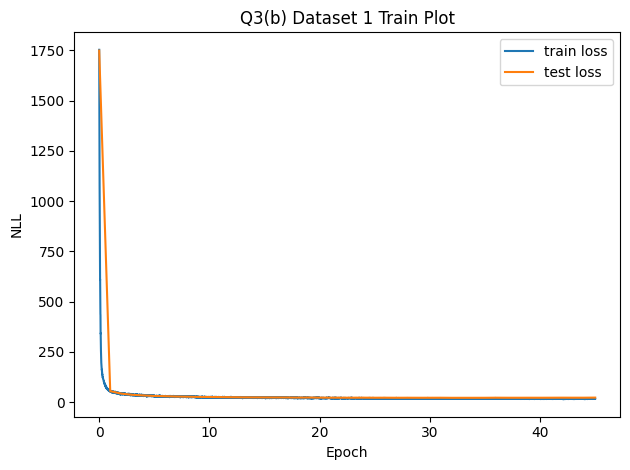

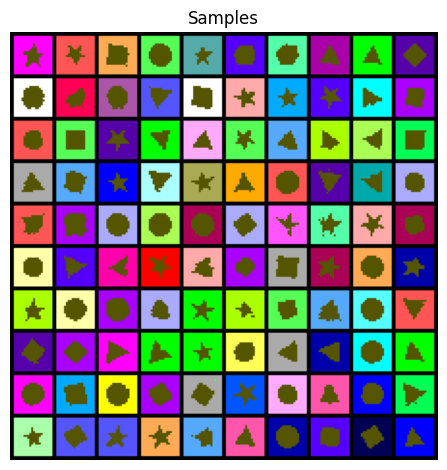

In [10]:
q3ab_save_results(1, 'b', q3_b)

Epoch 0: 100%|██████████| 938/938 [01:04<00:00, 14.50it/s]


test loss: 372.9706613334121
Best model updated at epoch 0 with test loss 372.9707


Epoch 1: 100%|██████████| 938/938 [01:05<00:00, 14.33it/s]


test loss: 322.12999633011543
Best model updated at epoch 1 with test loss 322.1300


Epoch 2: 100%|██████████| 938/938 [01:05<00:00, 14.29it/s]


test loss: 271.2229457782332
Best model updated at epoch 2 with test loss 271.2229


Epoch 3: 100%|██████████| 938/938 [01:05<00:00, 14.29it/s]


test loss: 228.37455671759926
Best model updated at epoch 3 with test loss 228.3746


Epoch 4: 100%|██████████| 938/938 [01:05<00:00, 14.27it/s]


test loss: 195.92357008624228
Best model updated at epoch 4 with test loss 195.9236


Epoch 5: 100%|██████████| 938/938 [01:05<00:00, 14.29it/s]


test loss: 162.4964273051851
Best model updated at epoch 5 with test loss 162.4964


Epoch 6: 100%|██████████| 938/938 [01:05<00:00, 14.29it/s]


test loss: 151.97188971452653
Best model updated at epoch 6 with test loss 151.9719


Epoch 7: 100%|██████████| 938/938 [01:05<00:00, 14.29it/s]


test loss: 133.1186722190517
Best model updated at epoch 7 with test loss 133.1187


Epoch 8: 100%|██████████| 938/938 [01:05<00:00, 14.29it/s]


test loss: 127.86408296815908
Best model updated at epoch 8 with test loss 127.8641


Epoch 9: 100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


test loss: 125.69759932596972
Best model updated at epoch 9 with test loss 125.6976
Saved checkpoint at epoch 10


Epoch 10: 100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


test loss: 126.85908785291538


Epoch 11: 100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


test loss: 111.42937945712144
Best model updated at epoch 11 with test loss 111.4294


Epoch 12: 100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


test loss: 102.90738789746716
Best model updated at epoch 12 with test loss 102.9074


Epoch 13: 100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


test loss: 100.16356430539659
Best model updated at epoch 13 with test loss 100.1636


Epoch 14: 100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


test loss: 98.1497705058687
Best model updated at epoch 14 with test loss 98.1498


Epoch 15: 100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


test loss: 270.18939354768986


Epoch 16: 100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


test loss: 157.72610065435907


Epoch 17: 100%|██████████| 938/938 [01:05<00:00, 14.29it/s]


test loss: 122.49733977105207


Epoch 18: 100%|██████████| 938/938 [01:05<00:00, 14.29it/s]


test loss: 108.49958028611104


Epoch 19: 100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


test loss: 128.00228434763136
Saved checkpoint at epoch 20


Epoch 20: 100%|██████████| 938/938 [01:05<00:00, 14.29it/s]


test loss: 103.10157644672758


Epoch 21: 100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


test loss: 102.64394305769805


Epoch 22: 100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


test loss: 90.7869505183712
Best model updated at epoch 22 with test loss 90.7870


Epoch 23: 100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


test loss: 88.41131305087144
Best model updated at epoch 23 with test loss 88.4113


Epoch 24: 100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


test loss: 95.11661310864102


Epoch 25: 100%|██████████| 938/938 [01:05<00:00, 14.31it/s]


test loss: 86.21686685161227
Best model updated at epoch 25 with test loss 86.2169


Epoch 26: 100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


test loss: 161.7661031735171


Epoch 27: 100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


test loss: 98.52286087327703


Epoch 28: 100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


test loss: 89.26935927275639


Epoch 29: 100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


test loss: 91.02232166460365
Saved checkpoint at epoch 30


Epoch 30: 100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


test loss: 111.4701306774358


Epoch 31: 100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


test loss: 81.65867260003546
Best model updated at epoch 31 with test loss 81.6587


Epoch 32: 100%|██████████| 938/938 [01:05<00:00, 14.29it/s]


test loss: 79.49618729512403
Best model updated at epoch 32 with test loss 79.4962


Epoch 33: 100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


test loss: 81.60818014934564


Epoch 34: 100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


test loss: 78.89099966644481
Best model updated at epoch 34 with test loss 78.8910


Epoch 35: 100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


test loss: 79.44579120806068


Epoch 36: 100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


test loss: 77.21212447828547
Best model updated at epoch 36 with test loss 77.2121


Epoch 37: 100%|██████████| 938/938 [01:05<00:00, 14.31it/s]


test loss: 76.90654152062288
Best model updated at epoch 37 with test loss 76.9065


Epoch 38: 100%|██████████| 938/938 [01:06<00:00, 14.15it/s]


test loss: 79.89178768085067


Epoch 39: 100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


test loss: 79.08246952712915
Saved checkpoint at epoch 40


Epoch 40: 100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


test loss: 76.44519548355395
Best model updated at epoch 40 with test loss 76.4452


Epoch 41: 100%|██████████| 938/938 [01:13<00:00, 12.85it/s]


test loss: 76.48576043973303


Epoch 42: 100%|██████████| 938/938 [01:14<00:00, 12.66it/s]


test loss: 76.1764997737423
Best model updated at epoch 42 with test loss 76.1765


Epoch 43: 100%|██████████| 938/938 [01:14<00:00, 12.66it/s]


test loss: 74.94804819678045
Best model updated at epoch 43 with test loss 74.9480


Epoch 44: 100%|██████████| 938/938 [01:14<00:00, 12.54it/s]


test loss: 80.0473348046564


Epoch 45: 100%|██████████| 938/938 [01:14<00:00, 12.57it/s]


test loss: 74.81802523667645
Best model updated at epoch 45 with test loss 74.8180


Epoch 46: 100%|██████████| 938/938 [01:14<00:00, 12.56it/s]


test loss: 73.37506263878694
Best model updated at epoch 46 with test loss 73.3751


Epoch 47: 100%|██████████| 938/938 [01:14<00:00, 12.55it/s]


test loss: 74.44795528338973


Epoch 48: 100%|██████████| 938/938 [01:14<00:00, 12.58it/s]


test loss: 73.37020572735246
Best model updated at epoch 48 with test loss 73.3702


Epoch 49: 100%|██████████| 938/938 [01:15<00:00, 12.45it/s]


test loss: 73.52855113813072
Saved checkpoint at epoch 50


Epoch 50: 100%|██████████| 938/938 [01:16<00:00, 12.29it/s]


test loss: 118.97548845619153


Epoch 51: 100%|██████████| 938/938 [01:13<00:00, 12.68it/s]


test loss: 73.01053578079126
Best model updated at epoch 51 with test loss 73.0105


Epoch 52: 100%|██████████| 938/938 [01:14<00:00, 12.58it/s]


test loss: 73.77900341058233


Epoch 53: 100%|██████████| 938/938 [01:07<00:00, 13.94it/s]


test loss: 72.87791214475206
Best model updated at epoch 53 with test loss 72.8779


Epoch 54: 100%|██████████| 938/938 [01:05<00:00, 14.29it/s]


test loss: 72.54468079585179
Best model updated at epoch 54 with test loss 72.5447


Epoch 55: 100%|██████████| 938/938 [01:05<00:00, 14.29it/s]


test loss: 74.50716988144407


Epoch 56: 100%|██████████| 938/938 [01:05<00:00, 14.29it/s]


test loss: 73.06632349293703


Epoch 57: 100%|██████████| 938/938 [01:05<00:00, 14.29it/s]


test loss: 133.42166745131183


Epoch 58: 100%|██████████| 938/938 [01:05<00:00, 14.29it/s]


test loss: 72.20296854881724
Best model updated at epoch 58 with test loss 72.2030


Epoch 59: 100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


test loss: 73.92959410066058
Saved checkpoint at epoch 60


Epoch 60: 100%|██████████| 938/938 [01:05<00:00, 14.29it/s]


test loss: 71.52113765060523
Best model updated at epoch 60 with test loss 71.5211


Epoch 61: 100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


test loss: 72.24341945283732


Epoch 62: 100%|██████████| 938/938 [01:05<00:00, 14.29it/s]


test loss: 71.71787869398761


Epoch 63: 100%|██████████| 938/938 [01:05<00:00, 14.29it/s]


test loss: 72.0822573133335


Epoch 64: 100%|██████████| 938/938 [01:06<00:00, 14.16it/s]


test loss: 71.2347374448351
Best model updated at epoch 64 with test loss 71.2347
Final Test Loss: 71.2347


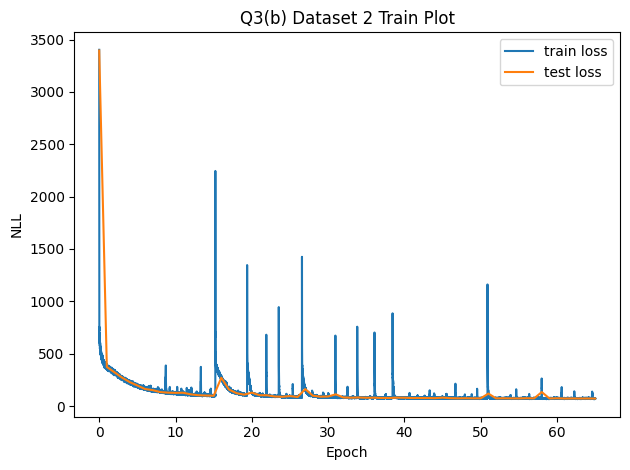

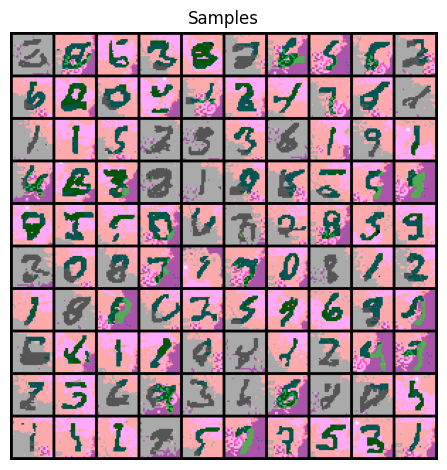

In [11]:
q3ab_save_results(2, 'b', q3_b)

## Part (c) K, V Caching for Improved Inference
You may have noticed that generation from the transformer is quite slow. Part of this is just due to the autoregressive nature. However, another part is due to some computational inefficiency. At each forward pass of the model, we are performing repeat computation of the past sequence. Specifically, we can cache the key and values at the multi attention layer to more quickly predict at each step.

In self-attention, a sequence is processed by generating three vectors for each element in the sequence: a Query (Q), a Key (K), and a Value (V). These vectors are then used to compute attention scores and subsequently the output of the attention layer.
Mathematically, this can be represented as:
 * For each index $i$, compute $Q_i$, $K_i$, $V_i$ for the current element
 * Retrieve $K_{<i}$ and $V_{<i}$ from the cache (where $<i$ denotes all indices before the current one)
 * Compute the attention output using $Q_i$, $[K_{<i}, K_i]$, $[V_{<i}, V_i]$


Next implement caching for your transformer to make inference more efficient by modifying your self attention. Use caching for inference in the future problems for faster generation! (Note caching is only used during inference). You will use the same dataset as in part B, dataset 2 of this question (colored mnist). No training is required in this section, feel free to reuse the model you trained in part B, dataset 2.

**You will provide these deliverables**

1. Over the course of inference, measure the time for the forward pass over the total sequence length with and without caching.
3. 100 samples from the final trained model using the caching inference pipeline.



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import math
import tqdm
import time

class LearnedPositionalEncoding(nn.Module):
  def __init__(self, max_len, d_model):
    super().__init__()
    self.pos_embed = nn.Embedding(max_len, d_model)

  def forward(self, x):
    B, T, _ = x.shape
    positions = torch.arange(T, device=x.device).unsqueeze(0).expand(B, T)
    return self.pos_embed(positions)

class MaskedMultiHeadAttention(nn.Module):
  def __init__(self, d_model, n_heads):
    super().__init__()
    self.n_heads = n_heads
    self.d_model = d_model
    self.head_dim = d_model // n_heads
    assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
    self.qkv_proj = nn.Linear(d_model, d_model * 3)
    self.out_proj = nn.Linear(d_model, d_model)
    
  def forward(self, x, mask):
    B, T, D = x.shape
    qkv = self.qkv_proj(x).reshape(B, T, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4) # (3, B, n_heads, T, head_dim)
    q, k, v = qkv[0], qkv[1], qkv[2]  # (B, n_heads, T, head_dim)

    scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)
    scores = scores.masked_fill(mask == 0, float('-inf'))
    attn = F.softmax(scores, dim=-1)

    out = (attn @ v).transpose(1, 2).reshape(B, T, D)
    return self.out_proj(out)

class TransformerBlock(nn.Module):
  def __init__(self, d_model, n_heads):
    super().__init__()
    self.attn = MaskedMultiHeadAttention(d_model, n_heads)
    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)
    self.ff = nn.Sequential(
        nn.Linear(d_model, d_model * 4),
        nn.GELU(),
        nn.Linear(d_model * 4, d_model)
    )
  def forward(self, x, mask):
    """
    x: (B, T, d_model)
    mask: (B, T, T) where mask[i, j] = 1 if position i attends to position j, else 0
    """
    x = x + self.attn(self.norm1(x), mask)
    x = x + self.ff(self.norm2(x))
    return x
  
class AutoregressiveTransformer(nn.Module):
  def __init__(self, seq_len, d_model=128, n_heads=4, n_layers=2, vocab_size=64):
    super().__init__()
    self.seq_len = seq_len
    self.d_model = d_model
    self.n_heads = n_heads
    self.n_layers = n_layers
    self.vocab_size = vocab_size

    self.token_embed = nn.Embedding(vocab_size, d_model)
    self.pos_embed = LearnedPositionalEncoding(seq_len, d_model)
    self.transformer_blocks = nn.ModuleList([
      TransformerBlock(d_model, n_heads) for _ in range(n_layers)
    ])
    self.norm = nn.LayerNorm(d_model)
    self.output_proj = nn.Linear(d_model, vocab_size)
  def forward(self, x):
    """
    x: (B, T)
    """
    B, T = x.shape
    token_embeddings = self.token_embed(x) # (B, T, d_model)
    pos_embeddings = self.pos_embed(token_embeddings) # (B, T, d_model)
    x = token_embeddings + pos_embeddings # (B, T, d_model)
    mask = torch.tril(torch.ones(T, T, device=x.device)).unsqueeze(0).unsqueeze(0) # (1, 1, T, T)
    for block in self.transformer_blocks:
      x = block(x, mask)
    x = self.norm(x)
    logits = self.output_proj(x)
    return logits # (B, T, vocab_size)
  
  def sample(self, batch_size, device):
    x = torch.zeros(batch_size, 1, dtype=torch.long, device=device) # <bos>
    for _ in range(self.seq_len - 1):
      logits = self.forward(x) # (B, T, vocab_size)
      probs = F.softmax(logits[:, -1, :], dim=-1) # (B, vocab_size)
      next_token = torch.multinomial(probs, num_samples=1)
      x = torch.cat([x, next_token], dim=1)
    return x # (B, T)

def sample_no_cache(model, batch_size, seq_len, device):
  model.eval()
  x = torch.zeros(batch_size, 1, dtype=torch.long, device=device)
  time_list = []
  for t in range(seq_len - 1):
    start = time.time()
    logits = model(x)
    probs = F.softmax(logits[:, -1, :], dim=-1)
    next_token = torch.multinomial(probs, num_samples=1)
    x = torch.cat([x, next_token], dim=1)
    end = time.time()
    time_list.append(end - start)
  return x, time_list

@torch.no_grad()
def forward_one_step_with_cache(model, x_t, t, past_kv):
  B = x_t.size(0)
  device = x_t.device
  head_dim = model.d_model // model.n_heads

  token_embeddings = model.token_embed(x_t)  # (B, 1, d_model)
  pos = torch.full((B, 1), t, dtype=torch.long, device=device)
  pos_embeddings = model.pos_embed.pos_embed(pos)
  h = token_embeddings + pos_embeddings  # (B, 1, d_model)

  new_kv = []
  for i, block in enumerate(model.transformer_blocks):
    h_pre = h
    h_norm = block.norm1(h)
    qkv = block.attn.qkv_proj(h_norm).reshape(B, 1, 3, model.n_heads, head_dim).permute(2, 0, 3, 1, 4)
    q, k, v = qkv[0], qkv[1], qkv[2]

    if past_kv[i][0] is not None:
      k = torch.cat([past_kv[i][0], k], dim=2)
      v = torch.cat([past_kv[i][1], v], dim=2)

    scores = (q @ k.transpose(-2, -1)) / math.sqrt(head_dim)
    attn = F.softmax(scores, dim=-1)
    attn_out = (attn @ v).transpose(1, 2).reshape(B, 1, model.d_model)
    attn_out = block.attn.out_proj(attn_out)
    h = h_pre + attn_out
    h = h + block.ff(block.norm2(h))
    new_kv.append((k, v))

  h = model.norm(h)
  logits = model.output_proj(h)  # (B, 1, vocab_size)
  return logits, new_kv

def sample_with_cache(model, batch_size, seq_len, device):
  x = torch.zeros(batch_size, 1, dtype=torch.long, device=device)  # <bos>
  past_kv = [(None, None) for _ in range(model.n_layers)]
  time_list = []

  for t in range(seq_len - 1):
    start = time.time()
    logits, past_kv = forward_one_step_with_cache(model, x[:, -1:], t, past_kv)
    probs = F.softmax(logits[:, -1, :], dim=-1)
    next_token = torch.multinomial(probs, num_samples=1)
    x = torch.cat([x, next_token], dim=1)
    end = time.time()
    time_list.append(end - start)

  return x, time_list

def q3_c(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# sampling steps,) numpy array of time per sampling iteration, without caching
  - a (# sampling steps,) numpy array of time per sampling iteration, with without caching
  - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3} (sample generated without caching)
  - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3} (sample generated with caching)
  """
  H, W, C = image_shape
  seq_len = H * W + 1
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  model = AutoregressiveTransformer(seq_len=seq_len, d_model=128, n_heads=4, n_layers=2, vocab_size=64).to(device)
  state_dict = torch.load(f"/sharefs/xtwang/deepul/homeworks/hw1/checkpoints_{dset_id}/best_model.pth", map_location=device, weights_only=True)
  model.load_state_dict(state_dict)
  def rgb_to_token(img):  # (B, H, W, 3)
    r = img[..., 0]
    g = img[..., 1]
    b = img[..., 2]
    tokens = (r * 16 + g * 4 + b).astype(np.uint8)
    return tokens.reshape(len(img), -1)  # (B, H*W)

  def token_to_rgb(tokens, H, W):  # (B, H*W)
    r = (tokens // 16) % 4
    g = (tokens // 4) % 4
    b = tokens % 4
    return np.stack([r, g, b], axis=-1).reshape(-1, H, W, 3)  # (B, H, W, 3)

  with torch.no_grad():
    samples_no_cache, time_list_no_cache = sample_no_cache(model, 100, seq_len, device)
    samples_with_cache, time_list_with_cache = sample_with_cache(model, 100, seq_len, device)

  samples_no_cache = samples_no_cache[:, 1:].cpu().numpy()
  samples_with_cache = samples_with_cache[:, 1:].cpu().numpy()
  samples_no_cache = token_to_rgb(samples_no_cache, H, W)
  samples_with_cache = token_to_rgb(samples_with_cache, H, W)

  return time_list_no_cache, time_list_with_cache, samples_no_cache, samples_with_cache

### Results

Once you've implemented `q3_c`, execute the cells below to visualize and save your results



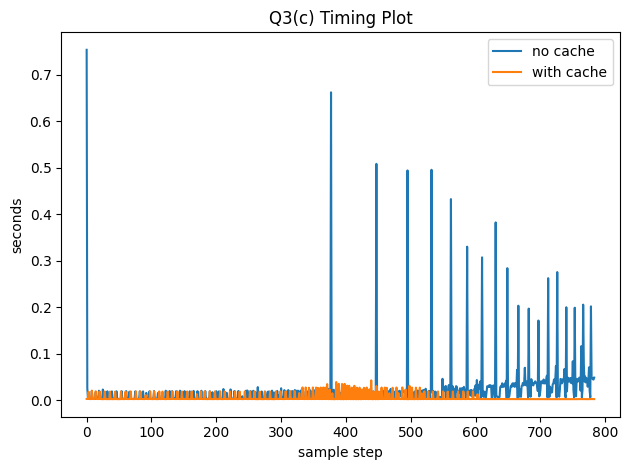

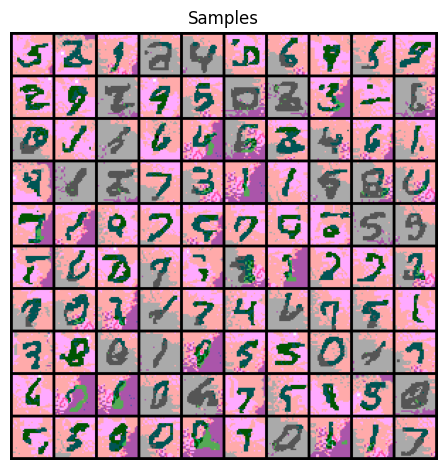

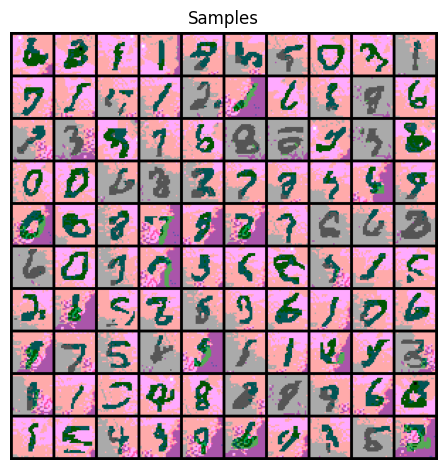

In [3]:
q3c_save_results(2, q3_c)

# Question 4: Causal Transformer: Tokenized Images

## Image Tokenization with Vector Quanization

## Part (a) Image Quantization

Above, we implemented iGPT, which autoregressivly predicts raw pixels. Transformers have quadratic complexity in the sequence length which prevents this naive approach from scaling well to large images.

The space of natural images often contains very correlated information. This suggests we can learn a reduced representation. VQVAE is a method that does just that, learning to map images to a more compact discrete set of tokens. We will cover this method in more detail in future lectures. The only thing you need to know now is that we can learn an encoder (and corresponding decoder), which can extract a discrete representation from an image. 

If you are curious, checkout the VQVAE paper to learn more: https://arxiv.org/abs/1711.00937 (we will cover this in a future lecture though!)

In this part, we provide a pre-trained VQVAE model, which consists of:
 * encoder to tokenize the images
 * the decoder to recover the image
 * a token vocabulary of VQVAE_MODEL.n_embeddings

Below is the code for loading the VQ model. Note that VQVAE encoding process is lossy, so the decoded images will not be the exact same as the input. Some blurriness in the recovered image is to be expected. The docstrings of the relevant methods you will need for the VQVAE_MODEL are provided below for your convenience. 

We will use 2 colored mnist datasets in this part. The first is the same dataset used in previous parts. The second, hads a colored digit on a differently colored background. We will call these datasets Colored MNIST and Colored MNIST v2. Note that the vqvae is trained per dataset.

**You will provide these deliverables**

1. Use the provided encoder model to quantize the images then inspect the recovered images by applying the decoder for each of the two datasets

In [ ]:
# @property
# def n_embeddings(self) -> int:
#     """The size of the token vocabulary"""
#    
# def quantize(self, x: np.ndarray) -> np.ndarray:
#     """Quantize an image x.
#
#     Args:
#         x (np.ndarray, dtype=int): Image to quantize. shape=(batch_size, 28, 28, 3). Values in [0, 3].
#
#     Returns:
#         np.ndarray: Quantized image. shape=(batch_size, 7, 7). Values in [0, n_embeddings]
#     """
#    
# def decode(self, z_index: np.ndarray) -> np.ndarray:
#     """Decode a quantized image.
#
#     Args:
#         z_index (np.ndarray, dtype=int): Quantized image. shape=(batch_size, 7, 7). Values in [0, n_embeddings].
#
#     Returns:
#         np.ndarray: Decoded image. shape=(batch_size, 28, 28, 3). Values in [0, 3].
#     """
# 

In [ ]:
def q4_a(images, vqvae):
  """
  images: (B, H, W, C), the images to pass through the encoder and decoder of the vqvae
  vqvae: a vqvae model, trained on the relevant dataset

  Returns
  - a numpy array of size (2, H, W, C) of the decoded image
  """
  return autoencoded_images

In [ ]:
q4a_save_results(1, q4_a)

In [ ]:
q4a_save_results(2, q4_a)

## Part (b) Autoregressive Transformer on Colored Shapes and MNIST with Vector Quantization

We can use the VQVAE to tokenize an image dataset. This will result in a much smaller sequence length than the approach we tried in Question 3(b). For this part, train a transformer on the dataset tokenized by the VQVAE.

This is a simplified version of the approach used in VQGAN [VQGAN](https://arxiv.org/abs/2012.09841) -> Section 3.2: Learning the Composition of Images with Transformers (Again, we will cover this in more detail in a future lecture!)

Update the following hyperparameters:
* layers: 4 (we can train a bigger transformer now since less memory is used per input!)
* 30 epochs

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 100 samples from the final trained model

In [ ]:
def q4_b(train_data, test_data, image_shape, dset_id, vqvae):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets
  vqvae: a vqvae model, trained on dataset dset_id

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3}
  """
  return train_losses, test_losses, samples

### Results

Once you've implemented `q4_b`, execute the cells below to visualize and save your results



In [ ]:
q4b_save_results(1, q4_b)

In [ ]:
q4b_save_results(2, q4_b)

# Question 5: Causal Transformer: Text

Now lets consider text! You are probably already fimilar with autoregressive transformers for text, now more commonly known as Large Language Modesl (LLMs).
We will now implement a simplified version.

We will be detailing with a [small poetry dataset](https://huggingface.co/datasets/merve/poetry). See some of the data below.

In [ ]:
data = visualize_q5_data()

## Part (a) Modeling Text
Train a transformer on the poetry dataset.

Data Preprocessing:
* We will use a simple method to tokenize the data. We will convert each unique character into a token. (Current LLMs use more sophisticated tokenizers, most commonly, [byte-pair encoding](https://huggingface.co/learn/nlp-course/chapter6/5?fw=pt))
* Previously we have leveraged a **\<bos\>** as part of the model, just like iGPT. For text, we may not always sample a sequence that starts at the beginning. Instead, we will add the **\<bos\>** token to the beginning of every sequence in the dataset, and remove the **\<bos\>** token from the model.
* Another problem is that the model must know when to stop sampling. This is done by appending an **\<eos\>**, or end of sequence token at the end of every sequence in the dataset.
* We can now convert the sequence into subsequences of size context_length, for training!

We recommend the following hyperparameters:
* Sequence length: 128
* 5 epochs

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. Provide **5 unconditional samples** of **128 characters** showcasing the model text generation capabilities (text samples should stop after **\<eos\>**. Text after **\<eos\>** can be removed in post processing)

In [ ]:
import torch.utils.data as data
def q5_a(train_text, test_text):
  """
  train_text: list[str] Train text sequences.
  test_text: list[str] Test text sequences.

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a list of 5 (str), 5 generated samples from the model.
  """
  return train_losses, test_losses, text_samples

### Results

Once you've implemented `q5_a`, execute the cells below to visualize and save your results



In [ ]:
q5a_save_results(q5_a)

# Question 6: Causal Transformer: Multimodal

So far, we have been dealing only with autoregressive generation of a single modality. Now we will train a model that operates on multiple modalities!

We will use the text labeled colored MNIST dataset, which has a text description of the MNIST image. Run the cell below to visualize the data along with the text annotation. This is the Colored MNIST v2 dataset, which also comes with these text labels.

In [ ]:
visualize_q6_data()

## Part (a) Multimodal Text and Image Generation
Implement and train an autoregressive (AR) model capable of handling both text and image data. The model should be designed to process sequences composed of concatenated text and image tokens in both orders (text followed by images and images followed by text). Additionally, the model should be capable of generating unconditional text and image samples.

Data Preprocessing:
* Text Tokens: Map each unique word in the text data to a unique token. (Note that all text descriptions contain the exact same amount of words. This simplifies text processing, as you won't have to deal with sequences of different lengths as in Question 5)
* Image Tokens: Quantize the image data into tokens using the VQVAE tokenizer from Problem 4.
* In this problem, we have 2 modalities. Introduce an **\<end of text\>** token and an **\<end of image\>** token. After seeing such a token, the model should switch to sampling the next modality.
* Formulate batches as sequences of concat([**\<end of image\>**, text_tokens, **\<end of text\>**, image_tokens]) and concat([**\<end of text\>**, image_tokens, **\<end of image\>**, text_tokens]). With a 50/50 split between each ordering.

Inference:
* During inference, we cannot mix modality tokens. During sampling we can restrict the logits to only be within the relevant modality.
* After **\<end of image\>**, only allow the model to sample text tokens (including **\<end of text\>**)
* After **\<end of text\>**, only allow the model to sample image tokens (including **\<end of image\>**)
* At the very start (conditioned on the **\<bos\>** token, only allow the model to sample one of (**\<end of image\>** or **\<end of text\>**))
* As the model may not always correctly sample the **\<end of image\>** token before the image ends, you may add a rule to force the model to always sample the correct number of image tokens (49 tokens).

You can use the same hyperparameters as in 4(b) (but of course, feel free to tune your model to achieve better performance)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 9 conditional samples based on provided text.
4. 9 conditional samples based on provided images.
5. 9 unconditional samples showcasing the model's capability in generating standalone text and images.

In [ ]:
def q6_a(train_data, test_data, image_shape, train_text, test_text, image_test_prompt, text_test_prompt, vqvae):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: tuple (H, W, C) The shape of the images in the dataset, indicating height, width, and number of color channels.
  train_text: list[str] Text data associated with each training image.
  test_text: list[str] Text data associated with each test image.
  image_test_prompt: (9, H, W, C) Image data used for generating conditional text samples during testing.
  text_test_prompt: list of 9 strings Text prompts used for generating conditional image samples during testing.
  vqvae: a vqvae model, trained on the relevant dataset

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a list of 9 (image, text), corresponding to the image conditioned samples
  - a list of 9 (image, text), corresponding to the text conditions samples
  - a list of 9 (image, text), corresponding to unconditional samples
  """
  return train_losses, test_losses, samples_image_conditioned, samples_text_conditioned, samples_unconditioned

### Results

Once you've implemented `q6_a`, execute the cells below to visualize and save your results



In [ ]:
q6a_save_results(q6_a)